In [28]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.datasets import make_blobs
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import numpy as np
from sklearn.metrics import silhouette_score
import PIL
import urllib.request
from pathlib import Path
import matplotlib.pyplot as plt

In [3]:
blob_centers = np.array([[ 0.2,  2.3], [-1.5 ,  2.3], [-2.8,  1.8],
                         [-2.8,  2.8], [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std,
                  random_state=7)

In [6]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
print("y_preds: ", kmeans.fit_predict(X))
kmeans.transform(X).round(2)

y_preds:  [2 2 4 ... 1 4 2]


array([[2.74, 1.45, 0.23, 1.54, 3.34],
       [2.82, 0.99, 0.27, 1.48, 3.4 ],
       [1.39, 4.09, 3.78, 2.68, 1.34],
       ...,
       [2.81, 0.07, 1.18, 1.4 , 3.29],
       [0.43, 3.06, 3.16, 1.72, 0.23],
       [2.58, 0.85, 0.44, 1.21, 3.14]], shape=(2000, 5))

In [8]:
good_init = np.array([[-3, 3], [-3, 2], [-3,1],[-1,2], [0,2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)
print(kmeans.inertia_)

211.5985372581684


In [10]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5, random_state=42)

In [12]:
silhouette_score(X, kmeans.labels_)

np.float64(0.6555176425728279)

In [22]:
homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
filename = "ladybug.png"
IMAGES_PATH = "/Users/chiragbangera/Developer/Handsonml/chpater_9/"
filepath = Path(IMAGES_PATH) / filename
print(filepath)
if not filepath.is_file():
    print("Downloading", filename)
    url = f"{homl3_root}/images/unsupervised_learning/{filename}"
    urllib.request.urlretrieve(url, filepath)

/Users/chiragbangera/Developer/Handsonml/chpater_9/ladybug.png


In [27]:
image = np.asarray(PIL.Image.open(filepath))
image.shape

(533, 800, 3)

In [37]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

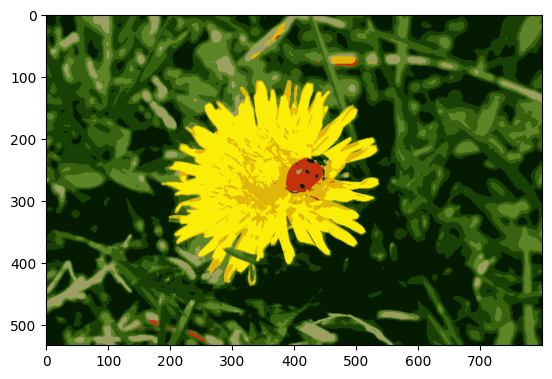

In [47]:
plt.imshow(segmented_img/255)

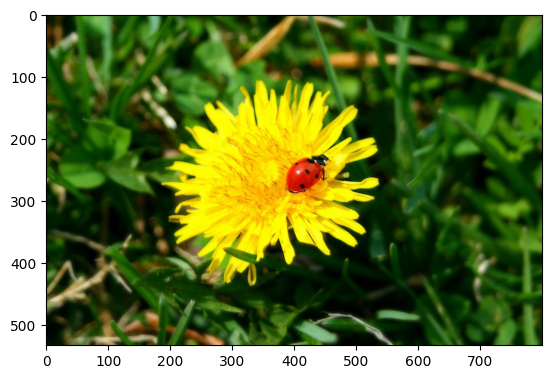

In [45]:
plt.imshow(image/255)

In [2]:
# semi supervised learning

X_digits, y_digits = load_digits(return_X_y=True)
X_train, y_train = X_digits[:1400], y_digits[:1400]
X_test, y_test = X_digits[1400:], y_digits[1400:]

In [5]:
n_labeled = 50
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.7581863979848866

In [35]:
k = 50
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train) # gives the distance to the centroids among the 50 clusters
representative_digit_idx = np.argmin(X_digits_dist, axis=0) # identifying the 50 images having lowest centroids
X_representative_digits = X_train[representative_digit_idx] #get the data the 50 data from the trainign set
y_representative_digits = y_train[representative_digit_idx]

In [36]:
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.8312342569269522

In [42]:
y_train_propagated = np.empty(len(X_train), dtype=np.int64)
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)

0.8664987405541562

In [84]:
# Ignoring the 1% of instances that are furthest from their cluster center this should eliminate some outliers
percentile_closest = 99

X_cluster_dist = X_digits_dist[np.arange(len(X_train)),kmeans.labels_] #distance from the closest cluster center
for i in range(k):
    in_cluster = (kmeans.labels_ == i) # all the instaces marked as ith cluster
    cluster_dist = X_cluster_dist[in_cluster] # filtering the ith cluster in the X_distances
    cutoff_distance = np.percentile(cluster_dist, percentile_closest) #calcualting the 99th percentile for the ith cluster
    above_cutoff = (X_cluster_dist > cutoff_distance) #filtering all the rows that are in the 99th percentile
    X_cluster_dist[in_cluster & above_cutoff] = -1 # setting any value in the ith cluster and above 99th percentile to -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [85]:
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.8589420654911839

In [16]:
X, y = make_moons(n_samples=1000, noise=0.05,random_state=42)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)
dbscan.labels_

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5,  2,  3,  0,  2,  2,  2,  4,
        2,  2,  4,  0,  5,  1,  0,  5,  5,  3,  2,  2,  2,  4,  5,  0,  6,
        1, -1,  0,  0,  2,  3, -1,  3,  4, -1,  4,  4,  2,  0,  6,  2,  0,
        2,  4,  0,  3,  3,  0,  3,  5,  2, -1,  3,  0,  5,  0,  0,  0,  2,
        3,  0,  3,  6,  0,  2,  4,  4,  0,  3,  0,  4,  0,  3, -1,  3,  4,
        0, -1,  2,  2,  4,  1,  6,  0,  5,  2,  6,  2,  3,  3, -1,  2, -1,
        2,  4,  0,  0,  0,  2,  5,  2,  0,  2, -1,  2,  3,  1,  5,  2,  0,
        4,  2,  1,  2,  4,  4,  0,  0,  6,  2,  2,  0,  2, -1,  2,  0,  3,
        3,  5, -1,  3,  3,  5,  2,  4,  2,  2,  2,  4,  2,  4,  0, -1,  2,
        1,  2,  6,  4,  2,  3,  2, -1,  2,  0,  0,  2,  0,  4,  0,  4,  4,
        1,  6,  3,  2,  6,  1,  4,  4,  2,  0,  6,  0,  1,  0,  2,  5,  1,
        1,  2,  2,  2,  2,  0,  5,  5,  1,  4,  5,  0,  3,  3,  0,  0,  0,
        2,  0,  5,  2, -1,  2,  3,  5,  2,  2,  0,  4,  0,  4,  2,  2,  4,
        2,  2,  3,  2,  3

In [4]:
print(dbscan.core_sample_indices_)
print(dbscan.components_)

[  0   1   2   3   5   6   7   8   9  10  11  12  13  14  15  16  18  19
  20  21  22  23  24  25  28  29  30  31  32  34  35  37  39  41  42  43
  44  45  47  51  53  54  55  56  57  58  59  61  62  63  64  65  67  68
  69  70  71  74  75  76  77  78  79  80  82  83  84  85  86  89  90  91
  92  93  94  96  97  98  99 100 104 105 107 108 109 110 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 127 128 129 130 131 133 134 136
 138 140 141 142 143 145 146 147 148 149 150 151 153 154 155 156 157 158
 160 161 162 163 166 167 168 170 171 172 173 175 177 178 179 180 181 183
 184 187 188 190 191 192 193 195 196 197 199 200 203 204 205 206 209 212
 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230
 231 232 233 234 235 236 237 240 241 242 244 245 247 248 249 250 251 252
 253 254 256 257 258 259 260 261 262 263 264 265 267 268 269 270 271 272
 274 275 276 277 278 279 280 281 282 283 285 286 287 288 290 292 297 298
 299 302 303 304 305 309 311 312 313 315 316 317 31

In [6]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [8]:
X_new = np.array([[-0.5, 0], [0,0.5], [1, -0.1], [2,1]])
print(knn.predict(X_new))
print(knn.predict_proba(X_new))


[5 2 9 7]
[[0.1  0.   0.04 0.   0.   0.86 0.   0.   0.   0.   0.  ]
 [0.32 0.   0.54 0.   0.02 0.   0.12 0.   0.   0.   0.  ]
 [0.26 0.02 0.   0.   0.   0.   0.   0.   0.   0.72 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.  ]]


In [9]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  6,  9, -1])

In [10]:
range(100)

range(0, 100)

In [12]:
# Gaussian mixture model

gm = GaussianMixture(n_components=3, n_init=10)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10)

In [17]:
print(gm.weights_)
print(gm.means_)
print(gm.covariances_)

[0.59345755 0.19159667 0.21494578]
[[ 0.53273737  0.22207757]
 [ 1.76854253 -0.02923971]
 [-0.71560872  0.58421784]]
[[[ 0.17181068 -0.1035139 ]
  [-0.1035139   0.28985368]]

 [[ 0.03860178  0.05073337]
  [ 0.05073337  0.08148641]]

 [[ 0.06523149  0.06892707]
  [ 0.06892707  0.08904751]]]


In [18]:
print(gm.converged_)
print(gm.n_iter_)

True
16


In [20]:
gm.predict(X)
gm.predict_proba(X).round(3)

array([[1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       ...,
       [0.019, 0.981, 0.   ],
       [0.   , 0.   , 1.   ],
       [1.   , 0.   , 0.   ]], shape=(1000, 3))

In [21]:
X_new, y_new = gm.sample(6)
X_new

array([[ 0.58986226,  0.02908644],
       [ 0.839542  , -0.66451181],
       [ 0.7163353 ,  0.35304352],
       [ 1.44705541, -1.08743407],
       [ 1.61763446, -0.45590187],
       [ 1.57546564, -0.17158821]])

In [22]:
y_new

array([0, 0, 0, 0, 1, 1])

In [24]:
print(gm.score_samples(X).round(3))

[-1.681e+00 -1.687e+00 -1.449e+00 -1.925e+00 -2.670e-01 -1.318e+00
 -1.630e+00 -1.676e+00 -1.600e-01 -1.806e+00 -2.349e+00 -1.609e+00
 -1.481e+00 -2.020e-01 -1.255e+00  2.260e-01 -1.740e+00 -6.280e-01
 -1.816e+00 -6.100e-01 -1.846e+00 -1.821e+00 -1.140e-01 -1.682e+00
 -1.629e+00 -1.851e+00 -1.633e+00 -9.210e-01 -1.760e-01 -4.790e-01
 -3.840e-01 -1.469e+00 -1.874e+00 -2.474e+00 -6.000e-03 -2.047e+00
 -1.543e+00 -1.334e+00 -1.580e-01 -1.474e+00 -1.426e+00 -1.620e+00
 -7.240e-01 -1.414e+00 -9.670e-01 -2.152e+00 -2.347e+00 -1.631e+00
 -4.150e-01 -1.183e+00 -1.899e+00 -7.240e-01 -2.058e+00 -1.673e+00
 -1.300e+00 -1.318e+00 -1.623e+00 -1.306e+00 -1.875e+00 -1.354e+00
 -2.188e+00 -1.565e+00 -2.159e+00 -1.742e+00 -1.642e+00 -1.478e+00
 -1.666e+00 -5.700e-02 -1.554e+00 -1.653e+00 -1.408e+00 -2.604e+00
 -1.700e+00 -1.731e+00 -1.996e+00 -1.645e+00 -1.547e+00 -1.319e+00
 -1.797e+00 -5.750e-01 -1.700e+00 -1.543e+00 -2.055e+00 -1.235e+00
 -8.230e-01 -1.623e+00 -1.661e+00 -1.635e+00 -1.731e+00 -8.340

In [25]:
# anomaly detection using GaussiaMixture

densities =gm.score_samples(X)
density_threshold = np.percentile(densities, 2)
anomalies = X[densities < density_threshold]

In [27]:
# Selecting number of clusters
print(gm.bic(X))
print(gm.aic(X))

2821.6699062619714
2738.238066519275


In [30]:
# Bayesian Mixture Models
bgm = BayesianGaussianMixture(n_components=10, n_init=20, random_state=42)
bgm.fit(X)
bgm.weights_.round(2)

array([0.13, 0.16, 0.12, 0.15, 0.13, 0.07, 0.12, 0.11, 0.  , 0.  ])

In [31]:
bgm.converged_

True

In [32]:
bgm.n_components

10

In [33]:
bgm.n_iter_

96

In [34]:
bgm.n_init

20